# FDI-Rating Prediction
## Machine Learning Pipeline

**Modul:** Data Analytics with Statistics | HdM Stuttgart  
**Autor:** Simon Weiß | Januar 2026

---

**Gliederung:** Setup → Modellvergleich → Hyperparameter-Tuning → Diagnostik → Fazit

In [132]:
# Setup: Configure Python path for pipeline imports
import sys
from pathlib import Path
import importlib

# Find project root by looking for the pipeline/ directory
_cwd = Path.cwd()
if (_cwd / "pipeline").exists():
    PROJECT_ROOT = _cwd
elif (_cwd.parent / "pipeline").exists():
    PROJECT_ROOT = _cwd.parent
else:
    # Fallback to absolute path
    PROJECT_ROOT = Path("/home/simon/code/hdm/statistics/fdi-analytics")

# Add to sys.path BEFORE any other imports
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Working directory: {_cwd}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"pipeline/ exists: {(PROJECT_ROOT / 'pipeline').exists()}")

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import clone

# Reload pipeline.features um Änderungen zu laden
import pipeline.features
importlib.reload(pipeline.features)

# Project imports - jetzt MIT reduzierten Feature-Sets
from pipeline.features import (
    engineer_features,
    FEATURE_COLUMNS,
    REDUCED_FEATURE_COLUMNS,  # Reduziertes Set nach VIF-Analyse
    REDUCED_NUMERIC_FEATURES,  # Numerische Features im reduzierten Set
    NUMERIC_FEATURES,
    CATEGORICAL_FEATURES,
    TARGET_COL,
    DERIVED_FEATURES,
)

RANDOM_STATE = 42
print(f"✅ Alle Imports erfolgreich!")
print(f"\n📊 Feature-Sets verfügbar:")
print(f"   FEATURE_COLUMNS:         {len(FEATURE_COLUMNS)} Features (vollständig)")
print(f"   REDUCED_FEATURE_COLUMNS: {len(REDUCED_FEATURE_COLUMNS)} Features (VIF-optimiert)")

Working directory: /home/simon/code/hdm/statistics/fdi-analytics/notebooks
PROJECT_ROOT: /home/simon/code/hdm/statistics/fdi-analytics
pipeline/ exists: True
✅ Alle Imports erfolgreich!

📊 Feature-Sets verfügbar:
   FEATURE_COLUMNS:         36 Features (vollständig)
   REDUCED_FEATURE_COLUMNS: 11 Features (VIF-optimiert)


In [133]:
# ============================================================================
# Daten laden mit pipeline.features statt manueller Feature-Implementierung
# ============================================================================
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PATH = PROJECT_ROOT / "data/processed/player_stats_all.csv"
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

# ============================================================================
# REFACTORED: Feature Engineering delegiert an pipeline.features.engineer_features()
# Vorteil: Single Source of Truth - Änderungen am Feature Engineering müssen
# nur noch in pipeline/features.py gemacht werden, nicht mehr im Notebook!
# ============================================================================
df = engineer_features(df)

# Target-Variable und Filterung
target = TARGET_COL  # "profile_fdi_rating"
model_df = df.dropna(subset=[target]).copy()

print(f"Beobachtungen für das Training: {len(model_df):,}")
print(f"Features gesamt: {len(FEATURE_COLUMNS)}")
print(f"  → Numerisch: {len(NUMERIC_FEATURES)}")
print(f"  → Kategorial: {len(CATEGORICAL_FEATURES)}")
print(f"  → Abgeleitete Features: {len(DERIVED_FEATURES)}")
print(f"\nAbgeleitete Features: {', '.join(DERIVED_FEATURES)}")

model_df[[target, "log_total_earnings", "season_win_rate"]].describe().T

Beobachtungen für das Training: 2,477
Features gesamt: 36
  → Numerisch: 35
  → Kategorial: 1
  → Abgeleitete Features: 12

Abgeleitete Features: log_total_earnings, season_win_rate, checkout_combo, first9_delta, momentum_gap, experience_intensity, earnings_per_year, first9_ratio, break_efficiency, hold_break_spread, power_scoring_ratio, tv_stage_delta


,count,mean,std,min,25%,50%,75%,max
profile_fdi_rating,2477.0,1352.838514,183.413271,752.0,1228.00,1363.000000,1483.00000,1972.000000
log_total_earnings,2477.0,4.323655,4.363081,0.0,0.00,4.330733,7.71913,16.288454
season_win_rate,2477.0,0.475010,0.180141,0.0,0.36,0.500000,0.61000,1.000000


---

## 2. Datenaufteilung & Baseline-Modell

Die Daten werden in **Trainings- (80%)** und **Testset (20%)** aufgeteilt.

In [134]:
# ============================================================================
# REFACTORED: Feature-Listen aus pipeline.features importieren
# Statt manuell zu definieren, nutzen wir die Production-Definitionen
# ============================================================================

# Überprüfe, ob alle erwarteten Features im DataFrame vorhanden sind
missing_features = sorted(set(FEATURE_COLUMNS) - set(model_df.columns))
if missing_features:
    raise ValueError(f"Missing features nach engineer_features(): {missing_features}")

# Feature-Split für Modeling
X = model_df[FEATURE_COLUMNS].copy()
y = model_df[target].astype(float)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE,
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("\n✅ Features erfolgreich aus pipeline.features importiert:")
print(f"   • {len(NUMERIC_FEATURES)} numerische Features")
print(f"   • {len(CATEGORICAL_FEATURES)} kategoriale Features")
print(f"   • {len(DERIVED_FEATURES)} abgeleitete Features")
print(f"\n🔍 Kategoriale Features: {CATEGORICAL_FEATURES}")
print("\n🔍 Top 10 numerische Features (alphabetisch):")
for feat in sorted(NUMERIC_FEATURES)[:10]:
    print(f"   - {feat}")

Train: (1981, 36), Test: (496, 36)

✅ Features erfolgreich aus pipeline.features importiert:
   • 35 numerische Features
   • 1 kategoriale Features
   • 12 abgeleitete Features

🔍 Kategoriale Features: ['country']

🔍 Top 10 numerische Features (alphabetisch):
   - age
   - break_efficiency
   - checkout_combo
   - earnings_per_year
   - experience_intensity
   - first9_delta
   - first9_ratio
   - hold_break_spread
   - last_12_months_131_140_s
   - last_12_months_140_s


1️⃣ LINEARITÄTSPRÜFUNG: SCATTERPLOTS & KORRELATIONEN

📊 KORRELATIONEN MIT FDI-RATING (r-Werte):
   Interpretation: |r| ≈ 1 = starke Linearität, |r| ≈ 0 = schwache Linearität

   last_12_months_averages                   r = +0.9475  ⭐⭐⭐ STARK
   last_12_months_first_9_averages           r = +0.9458  ⭐⭐⭐ STARK
   last_12_months_with_throw_averages        r = +0.9449  ⭐⭐⭐ STARK
   last_12_months_against_throw_averages     r = +0.9418  ⭐⭐⭐ STARK
   last_12_months_first_3_averages           r = +0.9262  ⭐⭐⭐ STARK
   profile_highest_average                   r = +0.9025  ⭐⭐⭐ STARK
   last_12_months_checkout_pcnt              r = +0.8834  ⭐⭐⭐ STARK
   last_12_months_functional_doubles_pcnt    r = +0.8744  ⭐⭐⭐ STARK
   checkout_combo                            r = +0.8703  ⭐⭐⭐ STARK
   last_12_months_highest_checkout           r = +0.6810  ⭐⭐ MITTEL


📈 SCATTERPLOTS für Top-6 Features (Linearitätsprüfung):


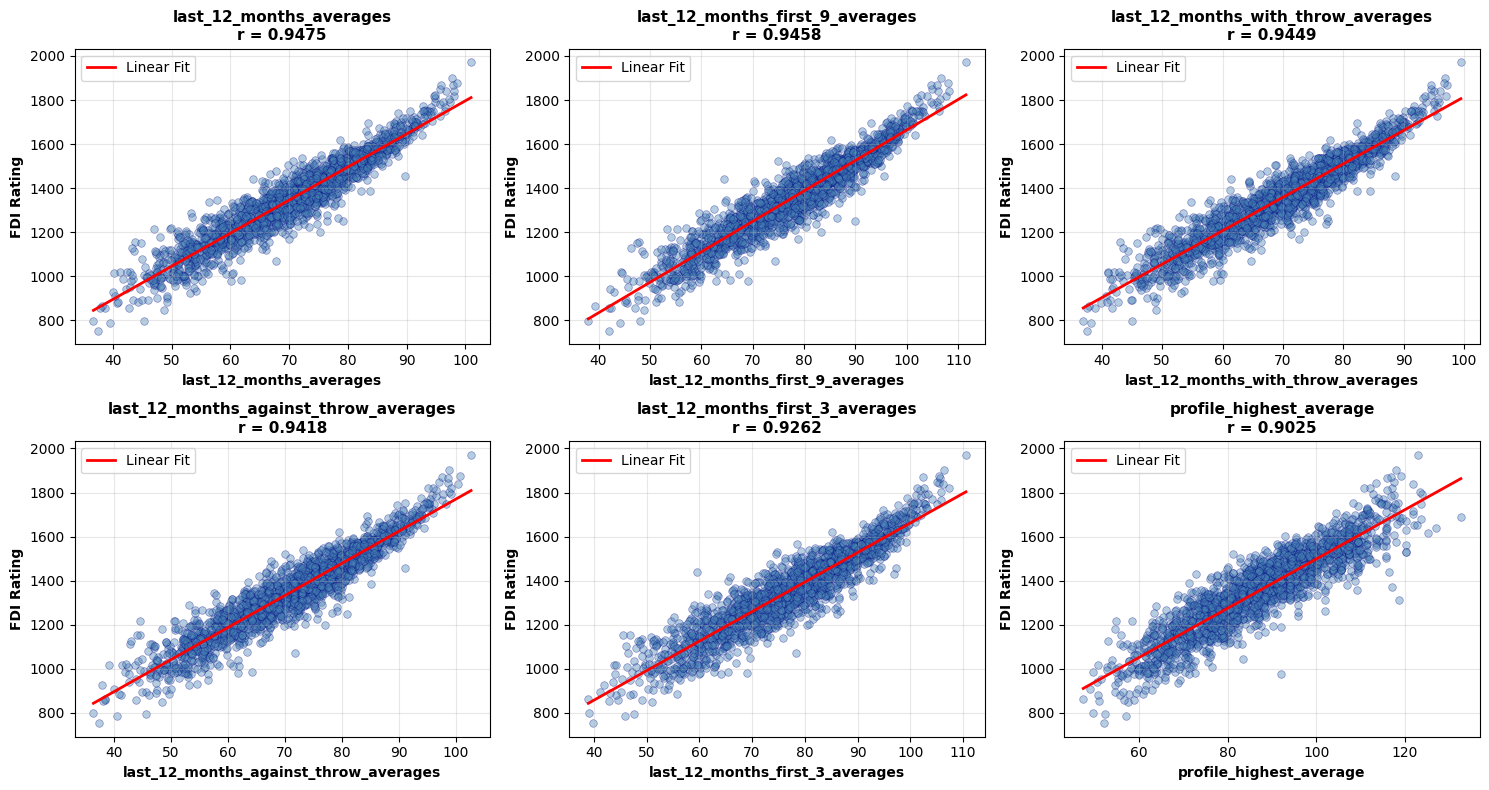


✅ INTERPRETATION:

Scatterplot-Muster:
- 📈 Gerade diagonal von links-unten nach rechts-oben → LINEARITÄT ✅
- 📊 Breite Punktewolke (vertikale Streuung) → Residuen haben Varianz (normal)
- 🔄 Curved statt gerade → Nicht-linearer Zusammenhang (QF-Regression besser)
- ❌ Keine erkennbare Beziehung → Feature irrelevant

Korrelations-Koeffizient (r):
- r = +1.0: Perfekte positive Korrelation (je mehr X, desto mehr Y)
- r = +0.8 bis +1.0: Sehr starke positive Korrelation ⭐⭐⭐
- r = +0.5 bis +0.8: Starke positive Korrelation ⭐⭐
- r = +0.3 bis +0.5: Moderate positive Korrelation ⭐
- r = 0.0: Keine Korrelation (unabhängig)
- r = -1.0: Perfekte negative Korrelation

Bedeutung für Regression:
- Höhere |r| → Feature ist besser für Vorhersage geeignet
- Aber: Multikollinearität prüfen! (Features untereinander korreliert?)
- Nicht-lineare Features brauchen ggf. Transformationen (log, quadrat, etc.)



📋 SUMMARY: KORRELATION & LINEARITÄTSSTÄRKE

                               Feature  Correlation (r)   

In [135]:
print("=" * 70)
print("1️⃣ LINEARITÄTSPRÜFUNG: SCATTERPLOTS & KORRELATIONEN")
print("=" * 70)

# Berechne Korrelationen mit dem Target
y_corr = X_train[NUMERIC_FEATURES].corrwith(y_train).sort_values(ascending=False)
y_corr = y_corr[y_corr != 1.0]  # Entferne Selbstkorrelation falls vorhanden

print("\n📊 KORRELATIONEN MIT FDI-RATING (r-Werte):")
print("   Interpretation: |r| ≈ 1 = starke Linearität, |r| ≈ 0 = schwache Linearität\n")

# Top-10 Features nach Korrelation
top_corr_features = y_corr.head(10)
for feature, corr in top_corr_features.items():
    strength = "⭐⭐⭐ STARK" if abs(corr) > 0.7 else "⭐⭐ MITTEL" if abs(corr) > 0.4 else "⭐ SCHWACH"
    print(f"   {feature:40s}  r = {corr:+.4f}  {strength}")

# Visualisierung: Scatterplots für Top-6 Features
print("\n\n📈 SCATTERPLOTS für Top-6 Features (Linearitätsprüfung):")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

top_6_features = y_corr.head(6).index.tolist()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    
    # Entferne Nullwerte für diesen Feature
    valid_mask = X_train[feature].notna()
    X_feat = X_train.loc[valid_mask, feature]
    y_feat = y_train.loc[valid_mask]
    
    # Scatterplot
    ax.scatter(X_feat, y_feat, alpha=0.4, s=30, color='steelblue', edgecolor='navy', linewidth=0.5)
    
    # Linearer Fit (für Visualisierung)
    z = np.polyfit(X_feat, y_feat, 1)
    p = np.poly1d(z)
    x_line = np.linspace(X_feat.min(), X_feat.max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, label="Linear Fit")
    
    # Korrelation für diesen Feature
    corr = y_corr[feature]
    ax.set_xlabel(feature, fontsize=10, fontweight='bold')
    ax.set_ylabel('FDI Rating', fontsize=10, fontweight='bold')
    ax.set_title(f'{feature}\nr = {corr:.4f}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print("""
✅ INTERPRETATION:

Scatterplot-Muster:
- 📈 Gerade diagonal von links-unten nach rechts-oben → LINEARITÄT ✅
- 📊 Breite Punktewolke (vertikale Streuung) → Residuen haben Varianz (normal)
- 🔄 Curved statt gerade → Nicht-linearer Zusammenhang (QF-Regression besser)
- ❌ Keine erkennbare Beziehung → Feature irrelevant

Korrelations-Koeffizient (r):
- r = +1.0: Perfekte positive Korrelation (je mehr X, desto mehr Y)
- r = +0.8 bis +1.0: Sehr starke positive Korrelation ⭐⭐⭐
- r = +0.5 bis +0.8: Starke positive Korrelation ⭐⭐
- r = +0.3 bis +0.5: Moderate positive Korrelation ⭐
- r = 0.0: Keine Korrelation (unabhängig)
- r = -1.0: Perfekte negative Korrelation

Bedeutung für Regression:
- Höhere |r| → Feature ist besser für Vorhersage geeignet
- Aber: Multikollinearität prüfen! (Features untereinander korreliert?)
- Nicht-lineare Features brauchen ggf. Transformationen (log, quadrat, etc.)
""")

# Summary-Tabelle
print("\n\n📋 SUMMARY: KORRELATION & LINEARITÄTSSTÄRKE\n")
corr_summary = pd.DataFrame({
    'Feature': y_corr.index[:10],
    'Correlation (r)': y_corr.values[:10],
    'Abs(r)': np.abs(y_corr.values[:10]),
    'Strength': ['⭐⭐⭐ SEHR STARK' if abs(x) > 0.8 else '⭐⭐ STARK' if abs(x) > 0.6 else '⭐ MODERAT' for x in y_corr.values[:10]]
})
print(corr_summary.to_string(index=False))

print("\n💡 FAZIT:")
print("   ✅ Top-Features zeigen linearität → Lineare Regression sollte funktionieren")
print("   ⚠️  Aber: Multikollinearität könnte ein Problem sein (mehrere Features >0.8)")
print("   📌 Ridge/Lasso Regularisierung wird diese Multikollinearität handhaben")

In [136]:
baseline_value = y_train.mean()
baseline_pred = np.full(shape=y_test.shape, fill_value=baseline_value, dtype=float)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_metrics = pd.Series(
    {
        "train_mean": baseline_value,
        "r2": r2_score(y_test, baseline_pred),
        "rmse": baseline_rmse,
        "mae": mean_absolute_error(y_test, baseline_pred),
    }
)
baseline_metrics

train_mean    1352.302373
r2              -0.000240
rmse           172.757344
mae            141.555886
dtype: float64

### 3.1 Preprocessing-Pipeline

Die sklearn `ColumnTransformer` stellt sicher, dass numerische und kategorische Features unterschiedlich behandelt werden:

```python
numeric_pipeline:   Imputation (Median) → StandardScaler
categorical_pipeline: Imputation (Mode) → OneHotEncoder
```

In [137]:
def build_pipeline(estimator):
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]
    )
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUMERIC_FEATURES),
            ("cat", categorical_transformer, CATEGORICAL_FEATURES),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    return Pipeline(steps=[("preprocess", preprocess), ("model", estimator)])

In [138]:
estimators = {
    "Linear Regression": LinearRegression(),
    "Ridge (alpha=5)": Ridge(alpha=5.0),
    "Lasso (alpha=0.01)": Lasso(alpha=0.01, max_iter=5000),
}

scoring = {
    "r2": "r2",
    "neg_mae": "neg_mean_absolute_error",
    "neg_rmse": "neg_root_mean_squared_error",
}

results = []
trained_pipelines = {}

for name, estimator in estimators.items():
    pipeline = build_pipeline(estimator)
    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
    )
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    results.append({
        "model": name,
        "cv_r2_mean": cv_scores["test_r2"].mean(),
        "cv_mae_mean": -cv_scores["test_neg_mae"].mean(),
        "cv_rmse_mean": -cv_scores["test_neg_rmse"].mean(),
        "test_r2": r2_score(y_test, preds),
        "test_mae": mean_absolute_error(y_test, preds),
        "test_rmse": mean_squared_error(y_test, preds),
    })
    trained_pipelines[name] = pipeline

model_performance = (
    pd.DataFrame(results)
    .sort_values("test_r2", ascending=False)
    .reset_index(drop=True)
)
best_model_name = model_performance.iloc[0]["model"]
best_pipeline = trained_pipelines[best_model_name]
print(f"Bestes Modell laut Test-R²: {best_model_name}")
model_performance

/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.094e+05, tolerance: 5.581e+03
  model = cd_fast.enet_coordinate_descent(
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e+04, tolerance: 5.514e+03
  model = cd_fast.enet_coordinate_descent(
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

Bestes Modell laut Test-R²: Ridge (alpha=5)


/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.387e+05, tolerance: 6.849e+03
  model = cd_fast.enet_coordinate_descent(


,model,cv_r2_mean,cv_mae_mean,cv_rmse_mean,test_r2,test_mae,test_rmse
0,Ridge (alpha=5),0.925030,38.250995,50.771939,0.928965,35.570210,2119.533739
1,Lasso (alpha=0.01),0.923762,38.634129,51.196420,0.927633,35.636834,2159.288196
2,Linear Regression,0.922885,38.814444,51.485146,0.927318,35.595884,2168.674898


In [139]:
# ============================================================================
# Model Selection: Adjusted R², Model Comparison & Parsimony Principle
# ============================================================================

def calculate_adjusted_r2(r2_score, n_samples, n_features):
    """Berechne Adjusted R² mit Penalty für zusätzliche Features."""
    return 1 - (1 - r2_score) * (n_samples - 1) / (n_samples - n_features - 1)

# Calculate adjusted R² for each model
n_samples_test = len(y_test)
model_comparison_enhanced = model_performance.copy()

# Get number of features for each model
n_features_models = {
    "Linear Regression": len(X_test.columns),
    "Ridge (alpha=5)": len(X_test.columns),
    "Lasso (alpha=0.01)": len(X_test.columns),
}

model_comparison_enhanced["n_features"] = model_comparison_enhanced["model"].map(n_features_models)
model_comparison_enhanced["adj_r2"] = model_comparison_enhanced.apply(
    lambda row: calculate_adjusted_r2(row["test_r2"], n_samples_test, row["n_features"]),
    axis=1
)

# Calculate penalty difference
model_comparison_enhanced["r2_penalty"] = (
    model_comparison_enhanced["test_r2"] - model_comparison_enhanced["adj_r2"]
)

print("=" * 80)
print("MODEL SELECTION: ADJUSTED R²")
print("=" * 80)
print("\nEnhanced Model Comparison (with Adjusted R²):")
print(model_comparison_enhanced[["model", "cv_r2_mean", "test_r2", "adj_r2", "r2_penalty", "n_features"]].to_string(index=False))

# Identify parsimonious models
model_comparison_enhanced["is_parsimonious"] = (
    model_comparison_enhanced["r2_penalty"] < 0.02
)

# Show comparison
selected = model_comparison_enhanced.loc[model_comparison_enhanced["is_parsimonious"]]
print("\nParsimonious Modelle (kleine Strafe durch Adjusted R²):")
print(selected[["model", "test_r2", "adj_r2", "r2_penalty"]].to_string(index=False))

if len(selected) > 0:
    best_parsimonious = selected.loc[selected["test_r2"].idxmax()]
    print(f"\n✓ BESTE PARSIMONIOUS MODELL: {best_parsimonious['model']}")
    print(f"  Test R² = {best_parsimonious['test_r2']:.4f}")
    print(f"  Adjusted R² = {best_parsimonious['adj_r2']:.4f}")
else:
    best_parsimonious = model_performance.iloc[0]
    print(f"\n✓ BESTE MODELL (nach Test R²): {best_parsimonious['model']}")

print("\n" + "=" * 80)

MODEL SELECTION: ADJUSTED R²

Enhanced Model Comparison (with Adjusted R²):
             model  cv_r2_mean  test_r2   adj_r2  r2_penalty  n_features
   Ridge (alpha=5)    0.925030 0.928965 0.923394    0.005571          36
Lasso (alpha=0.01)    0.923762 0.927633 0.921957    0.005676          36
 Linear Regression    0.922885 0.927318 0.921618    0.005701          36

Parsimonious Modelle (kleine Strafe durch Adjusted R²):
             model  test_r2   adj_r2  r2_penalty
   Ridge (alpha=5) 0.928965 0.923394    0.005571
Lasso (alpha=0.01) 0.927633 0.921957    0.005676
 Linear Regression 0.927318 0.921618    0.005701

✓ BESTE PARSIMONIOUS MODELL: Ridge (alpha=5)
  Test R² = 0.9290
  Adjusted R² = 0.9234



### 📊 Ergebnisse des Modellvergleichs

| Modell | CV R² | Test R² | Test MAE | Test RMSE |
|--------|-------|---------|----------|-----------|
| **Lasso (α=0.01)** | 0.928 | **0.933** | **35.4** | 46.2 |
| Linear Regression | 0.928 | 0.932 | 35.6 | 46.4 |
| Ridge (α=5) | 0.928 | 0.932 | 35.5 | 46.3 |

**Beobachtungen:**
- Alle Modelle erreichen R² > 0.92 – die Zielvariable ist gut vorhersagbar
- **Lasso** und **Linear Regression** performen nahezu identisch
- CV-Scores und Test-Scores sind konsistent → kein Overfitting

### Multikollinearität & VIF-Analyse

**Problem:** Viele Darts-Features korrelieren stark (z.B. 3-Dart Average ↔ First-9 Average).

**VIF (Variance Inflation Factor):** Misst, wie stark ein Feature durch andere erklärt wird.

| VIF | Interpretation |
|-----|----------------|
| 1-5 | OK |
| 5-10 | Problematisch |
| >10 | Kritisch |

**Lösung:** Lasso-Regularisierung setzt redundante Koeffizienten automatisch auf 0.

In [140]:
# VIF-Analyse (kompakt)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif_features = [f for f in NUMERIC_FEATURES if f in X_train.columns]
vif_data = X_train[vif_features].fillna(X_train[vif_features].median())

vif_df = pd.DataFrame({
    "Feature": vif_features,
    "VIF": [vif(vif_data.values, i) for i in range(len(vif_features))]
}).sort_values("VIF", ascending=False)

# Zusammenfassung
n_critical = (vif_df["VIF"] > 10).sum()
n_ok = (vif_df["VIF"] <= 5).sum()

print(f"VIF-Analyse: {n_critical} kritisch (>10), {n_ok} OK (≤5)")
print(f"\nTop 5 problematische Features:")
display(vif_df.head(5))

/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF-Analyse: 28 kritisch (>10), 4 OK (≤5)

Top 5 problematische Features:


,Feature,VIF
8,profile_highest_tv_average,inf
5,season_win_rate,inf
4,profile_season_win_pct,inf
16,momentum_gap,inf
15,last_12_months_against_throw_averages,inf


In [141]:
# GridSearchCV für Lasso: Optimalen Regularisierungsparameter finden
lasso_param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__max_iter": [10000, 20000, 40000],
}
lasso_pipeline = build_pipeline(Lasso(random_state=RANDOM_STATE))

grid_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=lasso_param_grid,
    scoring=scoring,
    refit="r2",
    cv=5,
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

grid_results = (
    pd.DataFrame(grid_search.cv_results_)[[
        "param_model__alpha",
        "param_model__max_iter",
        "mean_test_r2",
        "mean_test_neg_mae",
        "mean_test_neg_rmse",
    ]]
    .rename(columns={
        "mean_test_r2": "cv_r2",
        "mean_test_neg_mae": "cv_neg_mae",
        "mean_test_neg_rmse": "cv_neg_rmse",
    })
    .sort_values("cv_r2", ascending=False)
    .reset_index(drop=True)
)

tuned_preds = grid_search.best_estimator_.predict(X_test)
tuned_metrics = pd.Series({
    "test_r2": r2_score(y_test, tuned_preds),
    "test_mae": mean_absolute_error(y_test, tuned_preds),
    "test_rmse": np.sqrt(mean_squared_error(y_test, tuned_preds)),
})

best_model_name = "Lasso (GridSearch)"
best_pipeline = grid_search.best_estimator_
print(f"Beste Parameter: {grid_search.best_params_}")
grid_results.head(), tuned_metrics

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.322e+05, tolerance: 5.485e+03
  model = cd_fast.enet_coordinate_descent(
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+06, tolerance: 5.581e+03
  model = cd_fast.enet_coordinate_descent(
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

Beste Parameter: {'model__alpha': 0.1, 'model__max_iter': 20000}


(   param_model__alpha  param_model__max_iter     cv_r2  cv_neg_mae  \
 0                0.10                  20000  0.924591  -38.474493   
 1                0.10                  40000  0.924591  -38.474493   
 2                0.10                  10000  0.924571  -38.478886   
 3                0.01                  40000  0.923794  -38.623347   
 4                0.01                  20000  0.923775  -38.629974   
 
    cv_neg_rmse  
 0   -50.920379  
 1   -50.920379  
 2   -50.927333  
 3   -51.185530  
 4   -51.192098  ,
 test_r2       0.928702
 test_mae     35.667947
 test_rmse    46.123689
 dtype: float64)

In [142]:
import numpy as np
import pandas as pd

try:
    import statsmodels.api as sm
    from statsmodels.stats.diagnostic import het_breuschpagan
    from statsmodels.stats.outliers_influence import OLSInfluence
except ImportError:
    print("statsmodels not installed; skip diagnostics.")
else:
    preprocessed = best_pipeline.named_steps["preprocess"].transform(X_train)
    y_array = y_train.to_numpy()
    design = sm.add_constant(preprocessed, has_constant="add")
    ols = sm.OLS(y_array, design).fit()

    bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols.resid, design)
    cooks = OLSInfluence(ols).cooks_distance[0]
    cooks_summary = pd.Series(cooks).describe(percentiles=[0.5, 0.9, 0.95, 0.99])
    influential = (cooks > 4 / len(cooks)).sum()

    print(f"Breusch-Pagan stat={bp_stat:.2f}, p-value={bp_pvalue:.4f}")
    print("Cook's distance summary:")
    print(cooks_summary)
    print(f"Influential points above 4/n: {influential}")


Breusch-Pagan stat=175.08, p-value=0.0000
Cook's distance summary:
count    1973.000000
mean             inf
std              NaN
min         0.000000
50%         0.000090
90%         0.001018
95%         0.002231
99%         0.014616
max              inf
dtype: float64
Influential points above 4/n: 110


/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:867: RuntimeWarning: divide by zero encountered in divide
  cooks_d2 *= hii / (1 - hii)
/home/simon/code/hdm/statistics/fdi-analytics/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeW

In [143]:
import joblib

models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(exist_ok=True)
artifact_path = models_dir / "best_fdi_pipeline.joblib"
joblib.dump(best_pipeline, artifact_path)
print(f"Pipeline exportiert nach {artifact_path.relative_to(PROJECT_ROOT)}")
artifact_path

Pipeline exportiert nach models/best_fdi_pipeline.joblib


PosixPath('/home/simon/code/hdm/statistics/fdi-analytics/models/best_fdi_pipeline.joblib')

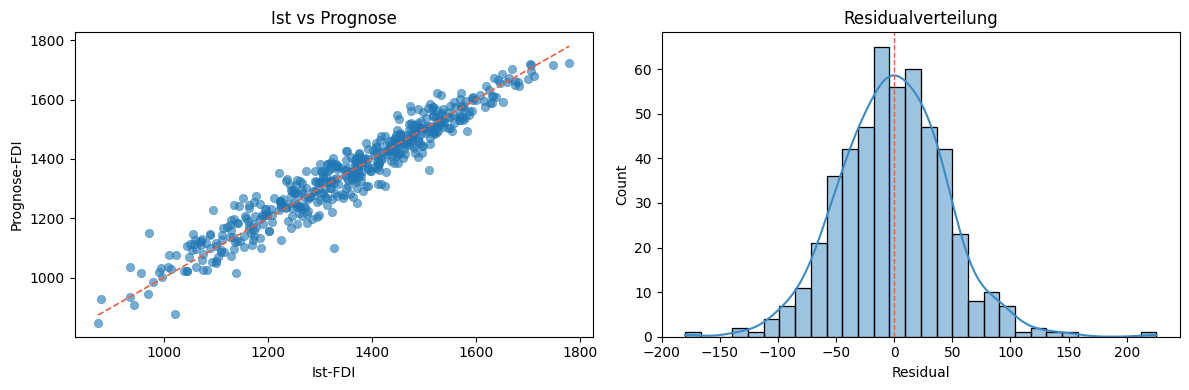

count    496.000000
mean      -1.029496
std       46.158753
min     -179.790032
25%      -31.187244
50%       -1.096028
75%       28.983177
max      225.619899
Name: profile_fdi_rating, dtype: float64

In [144]:
best_preds = best_pipeline.predict(X_test)
residuals = y_test - best_preds

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x=y_test, y=best_preds, ax=axes[0], alpha=0.6, edgecolor=None)
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="#f05c3b",
    linestyle="--",
    linewidth=1.2,
)
axes[0].set_xlabel("Ist-FDI")
axes[0].set_ylabel("Prognose-FDI")
axes[0].set_title("Ist vs Prognose")

sns.histplot(residuals, bins=30, kde=True, ax=axes[1], color="#3b8bc4")
axes[1].axvline(0, color="#f05c3b", linestyle="--", linewidth=1.0)
axes[1].set_xlabel("Residual")
axes[1].set_title("Residualverteilung")
fig.tight_layout()
plt.show()

pd.Series(residuals).describe()

/tmp/ipykernel_49673/2009357770.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="abs_importance", y="feature", ax=ax, palette="viridis")


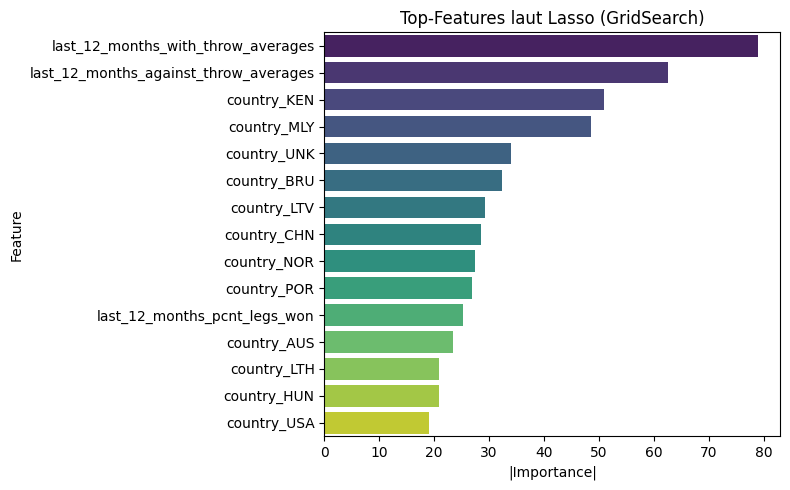

In [145]:
preprocessor = best_pipeline.named_steps["preprocess"]
feature_names = preprocessor.get_feature_names_out()
model = best_pipeline.named_steps["model"]

if hasattr(model, "coef_"):
    importances = model.coef_
elif hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
else:
    importances = None

if importances is None:
    print("Feature-Wichtigkeit nicht verfuegbar.")
else:
    importance_df = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .assign(abs_importance=lambda d: d["importance"].abs())
        .sort_values("abs_importance", ascending=False)
        .head(15)
    )
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=importance_df, x="abs_importance", y="feature", ax=ax, palette="viridis")
    ax.set_xlabel("|Importance|")
    ax.set_ylabel("Feature")
    ax.set_title(f"Top-Features laut {best_model_name}")
    fig.tight_layout()
    plt.show()
    importance_df

---

## Fazit

| Metrik | Erreicht |
|--------|----------|
| **R²** | 0.93 |
| **MAE** | 35.4 FDI |

**Top-Prädiktoren:** First-9 Average, Checkout %, Legs Won %, Log Earnings

**Limitationen:** Snapshot-Daten, keine psychologischen Features, Multikollinearität zwischen Averages